In [84]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, array_to_img, img_to_array
from sklearn.metrics import confusion_matrix
import itertools
import os
import random
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline


In [65]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs available:  1


In [66]:
if os.path.isdir('train/cracked') is False:
    os.makedirs('train/cracked')
    os.makedirs('train/noncracked')
    os.makedirs('valid/cracked')
    os.makedirs('valid/noncracked')
    os.makedirs('test/cracked')
    os.makedirs('test/noncracked')

    os.chdir('Cracked')

    for c in random.sample(glob.glob('cracked*'), 2966):
        shutil.move(c, '../train/cracked')
    for c in random.sample(glob.glob('cracked*'), 1000):
        shutil.move(c, '../valid/cracked')
    for c in random.sample(glob.glob('cracked*'), 1000):
        shutil.move(c, '../test/cracked')
    
    os.chdir('../Non-Cracked')

    for c in random.sample(glob.glob('noncracked*'), 39227):
        shutil.move(c, '../train/noncracked')
    for c in random.sample(glob.glob('noncracked*'), 1000):
        shutil.move(c, '../valid/noncracked')
    for c in random.sample(glob.glob('noncracked*'), 11000):
        shutil.move(c, '../test/noncracked')
    os.chdir('../')


In [70]:
print(len(os.listdir('train/cracked')))

2966


In [74]:
datagenerator = ImageDataGenerator(
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    horizontal_flip=True, 
    vertical_flip=True, 
    fill_mode="reflect")
while len(os.listdir('train/cracked')) < 39227:
    for file in os.listdir('train/cracked'):
        if len(os.listdir('train/cracked')) >= 39227:
            break
        img = load_img('train/cracked/' + file)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagenerator.flow(x, batch_size=1, save_to_dir='train/cracked', save_prefix='cracked_'+ str(random.randint(0,39227)), save_format='jpg'):
            i+=1
            if i > 20:
                break

while len(os.listdir('test/cracked')) < 1100:
    for file in os.listdir('test/cracked'):
        if len(os.listdir('test/cracked')) >= 11000:
            break
        img = load_img('test/cracked/' + file)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagenerator.flow(x, batch_size=1, save_to_dir='test/cracked', save_prefix='cracked_'+ str(random.randint(0,11000)), save_format='jpg'):
            i+=1
            if i > 20:
                break



In [75]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [76]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input).flow_from_directory(directory=train_path, target_size=(256,256), classes=['cracked', 'noncracked'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input).flow_from_directory(directory=valid_path, target_size=(256,256), classes=['cracked', 'noncracked'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input).flow_from_directory(directory=test_path, target_size=(256,256), classes=['cracked', 'noncracked'], batch_size=10, shuffle=False)

Found 78465 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 22008 images belonging to 2 classes.


In [77]:
imgs, labels = next(train_batches)

In [78]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

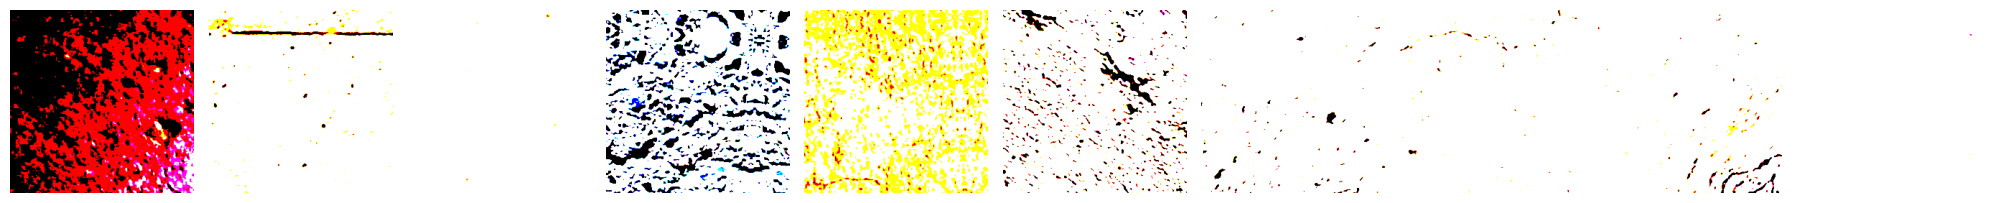

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [79]:
plotImages(imgs)
print(labels)

In [80]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding = 'same', input_shape=(256,256,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dropout(0.5),
    Dense(units=128, activation= "relu"),
    Dense(units=2, activation="sigmoid")
])

In [81]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 128)     

In [88]:
model.compile(
    optimizer=Adam(learning_rate=0.0000001), 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

In [89]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1.0e-15
)


model.fit(
    x=train_batches, 
    validation_data=valid_batches, 
    epochs=100, 
    verbose=2, 
    callbacks=[reduce_lr]
)

Epoch 1/100
7847/7847 - 124s - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.5972 - val_accuracy: 0.8020 - lr: 1.0000e-07 - 124s/epoch - 16ms/step
Epoch 2/100
7847/7847 - 125s - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.6120 - val_accuracy: 0.8015 - lr: 1.0000e-07 - 125s/epoch - 16ms/step
Epoch 3/100
7847/7847 - 126s - loss: 0.0444 - accuracy: 0.9863 - val_loss: 0.6176 - val_accuracy: 0.8015 - lr: 1.0000e-07 - 126s/epoch - 16ms/step
Epoch 4/100
7847/7847 - 128s - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.6167 - val_accuracy: 0.8005 - lr: 1.0000e-07 - 128s/epoch - 16ms/step
Epoch 5/100
7847/7847 - 125s - loss: 0.0441 - accuracy: 0.9861 - val_loss: 0.6201 - val_accuracy: 0.7995 - lr: 2.0000e-08 - 125s/epoch - 16ms/step
Epoch 6/100
7847/7847 - 127s - loss: 0.0439 - accuracy: 0.9864 - val_loss: 0.6213 - val_accuracy: 0.8005 - lr: 2.0000e-08 - 127s/epoch - 16ms/step
Epoch 7/100
7847/7847 - 128s - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.6249 - val_accuracy: 0.8005 - lr: 2.0000e

In [90]:
model.save('saved_model/damageDetectionModel', save_format='tf')

INFO:tensorflow:Assets written to: saved_model/damageDetectionModel\assets


INFO:tensorflow:Assets written to: saved_model/damageDetectionModel\assets


In [91]:
model = keras.models.load_model('saved_model/damageDetectionModel')

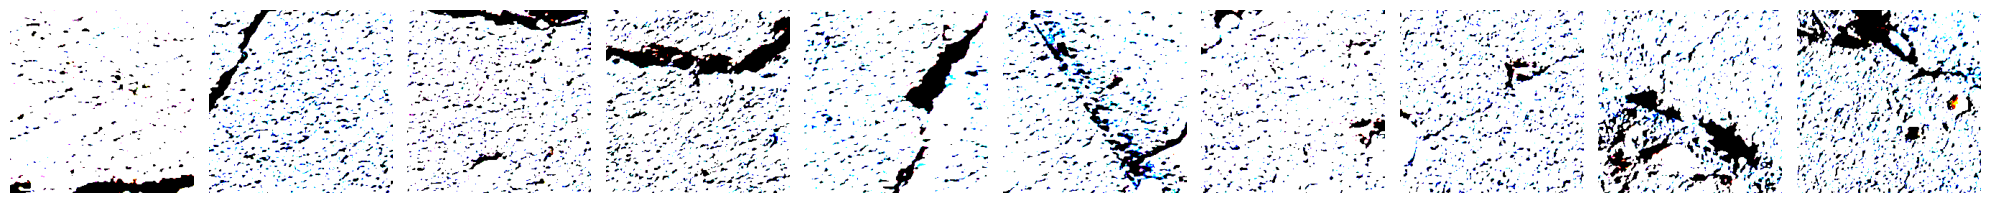

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [92]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [93]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [94]:
predictions = model.predict(x=test_batches, verbose=0)

In [95]:
np.round(predictions)

array([[0., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [96]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [97]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [98]:
test_batches.class_indices

{'cracked': 0, 'noncracked': 1}

confusion matrix, without normalization
[[10514   494]
 [  184 10816]]


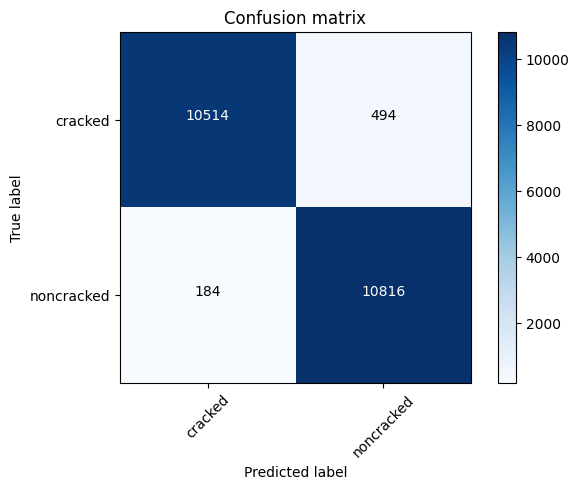

In [99]:
cm_plot_labels = ['cracked', 'noncracked']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')